In [332]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [333]:
original = cv.imread("data/C0383713713R_full.jpg")
image = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
image = cv.resize(image, (500, 500))
image = image[:425, :] # crop out the black parts. (for this example image)

## "automatic" canny edge detection
From this blog: https://pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/

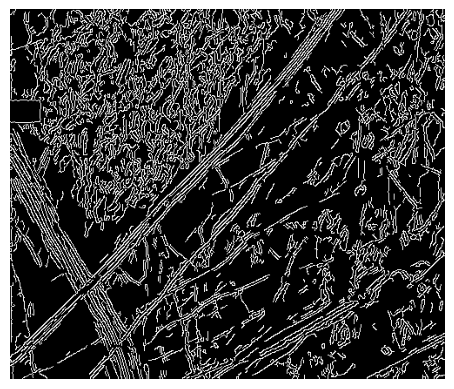

In [334]:
def imshow(image):
	plt.imshow(image, cmap="gray")
	plt.axis('off')
	plt.gcf().patch.set_alpha(0)
	plt.show()
	
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))

	return cv.Canny(image, lower, upper)

imshow(auto_canny(cv.GaussianBlur(image, (5,5), 0), 0.33))

## Testing Hough Transform on this method

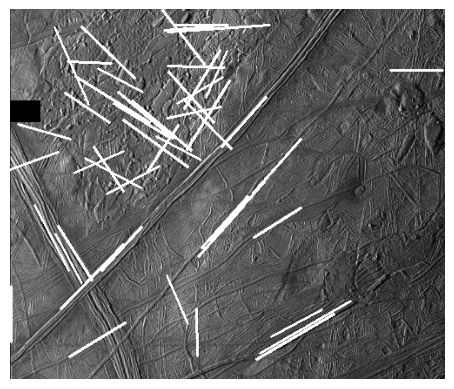

In [335]:
def houghP(processed_img, output=image):
    lines = cv.HoughLinesP(processed_img, 1, np.pi/90, 100, minLineLength=50, maxLineGap=5)
    output = output.copy()
    if lines is None:
        return output
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv.line(output, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return output

imshow(houghP(auto_canny(cv.GaussianBlur(image, (5,5), 0))))

## Testing preprocessing steps before canny edge detection

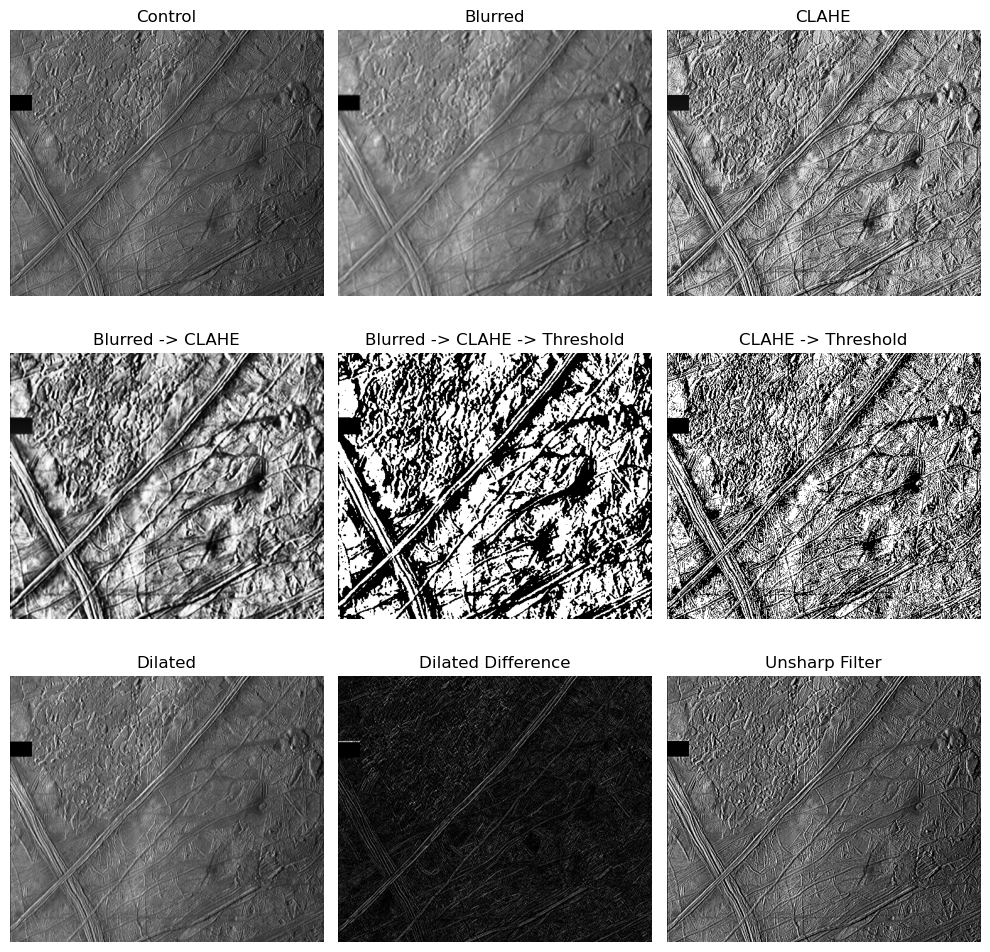

In [336]:
blurred = cv.GaussianBlur(image, (5,5), 0)
clahe = cv.createCLAHE(clipLimit=20.0, tileGridSize=(8,8))
clahe_img = clahe.apply(image)
blurred_clahe = clahe.apply(blurred)
_, blurred_clahe_thresh = cv.threshold(blurred_clahe,0,255,cv.THRESH_OTSU)
_, clahe_thresh = cv.threshold(clahe_img,0,255,cv.THRESH_OTSU)

dilated = cv.dilate(image, (5, 5), iterations=1)
dilated_diff = cv.dilate(cv.absdiff(dilated, image), (5, 5), iterations=1)

gauss = cv.GaussianBlur(image, (0, 0), 2)
unsharp_image = cv.addWeighted(image, 2.0, gauss, -1.0, 0)


images = [image, blurred, clahe_img,
        blurred_clahe, blurred_clahe_thresh, clahe_thresh,
        dilated, dilated_diff, unsharp_image]
titles = ["Control", "Blurred", "CLAHE",
        "Blurred -> CLAHE", "Blurred -> CLAHE -> Threshold", "CLAHE -> Threshold",
        "Dilated", "Dilated Difference", "Unsharp Filter"]
plt.figure(figsize=(10, 10))
for i, img in enumerate(images):
    plt.subplot(3, 3, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.gcf().patch.set_alpha(0)
plt.show()

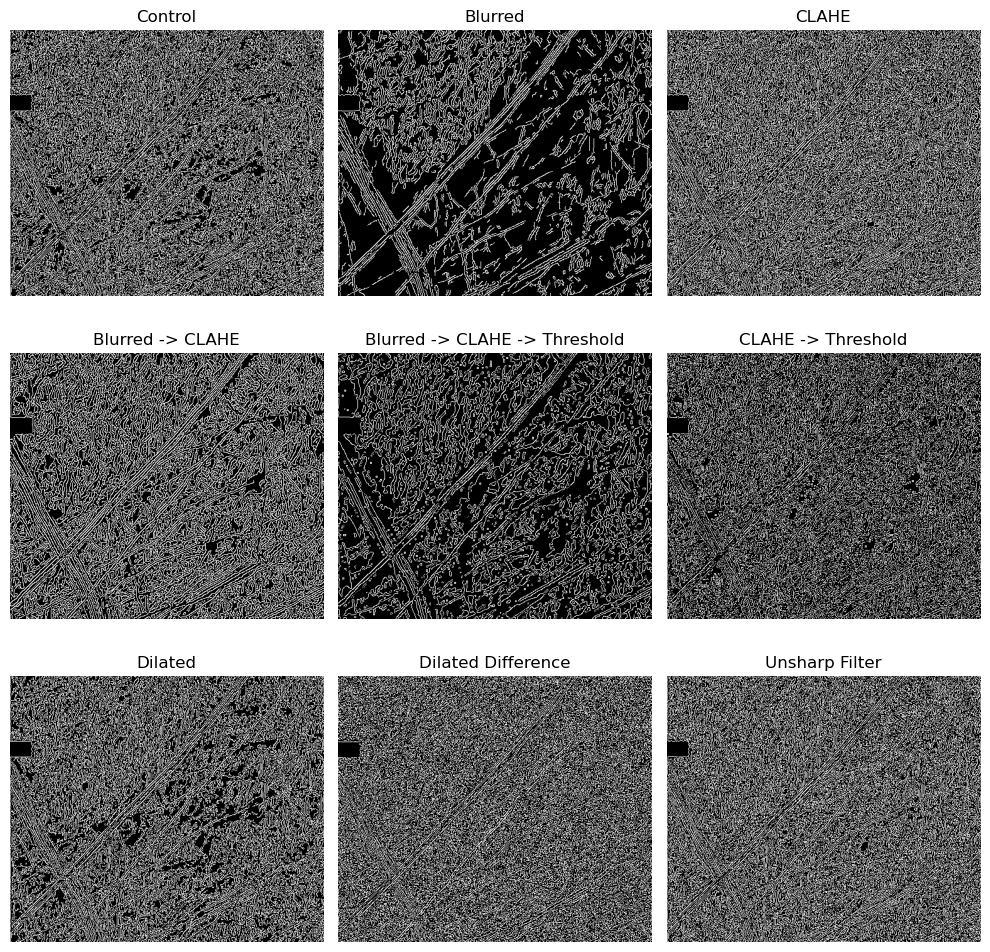

In [ ]:
plt.figure(figsize=(10, 10))
for i, img in enumerate(images):
    canny = auto_canny(img)
    plt.subplot(3, 3, i+1)
    plt.imshow(canny, cmap="gray")
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.gcf().patch.set_alpha(0)
plt.show()

## Testing processing steps between canny & hough filters

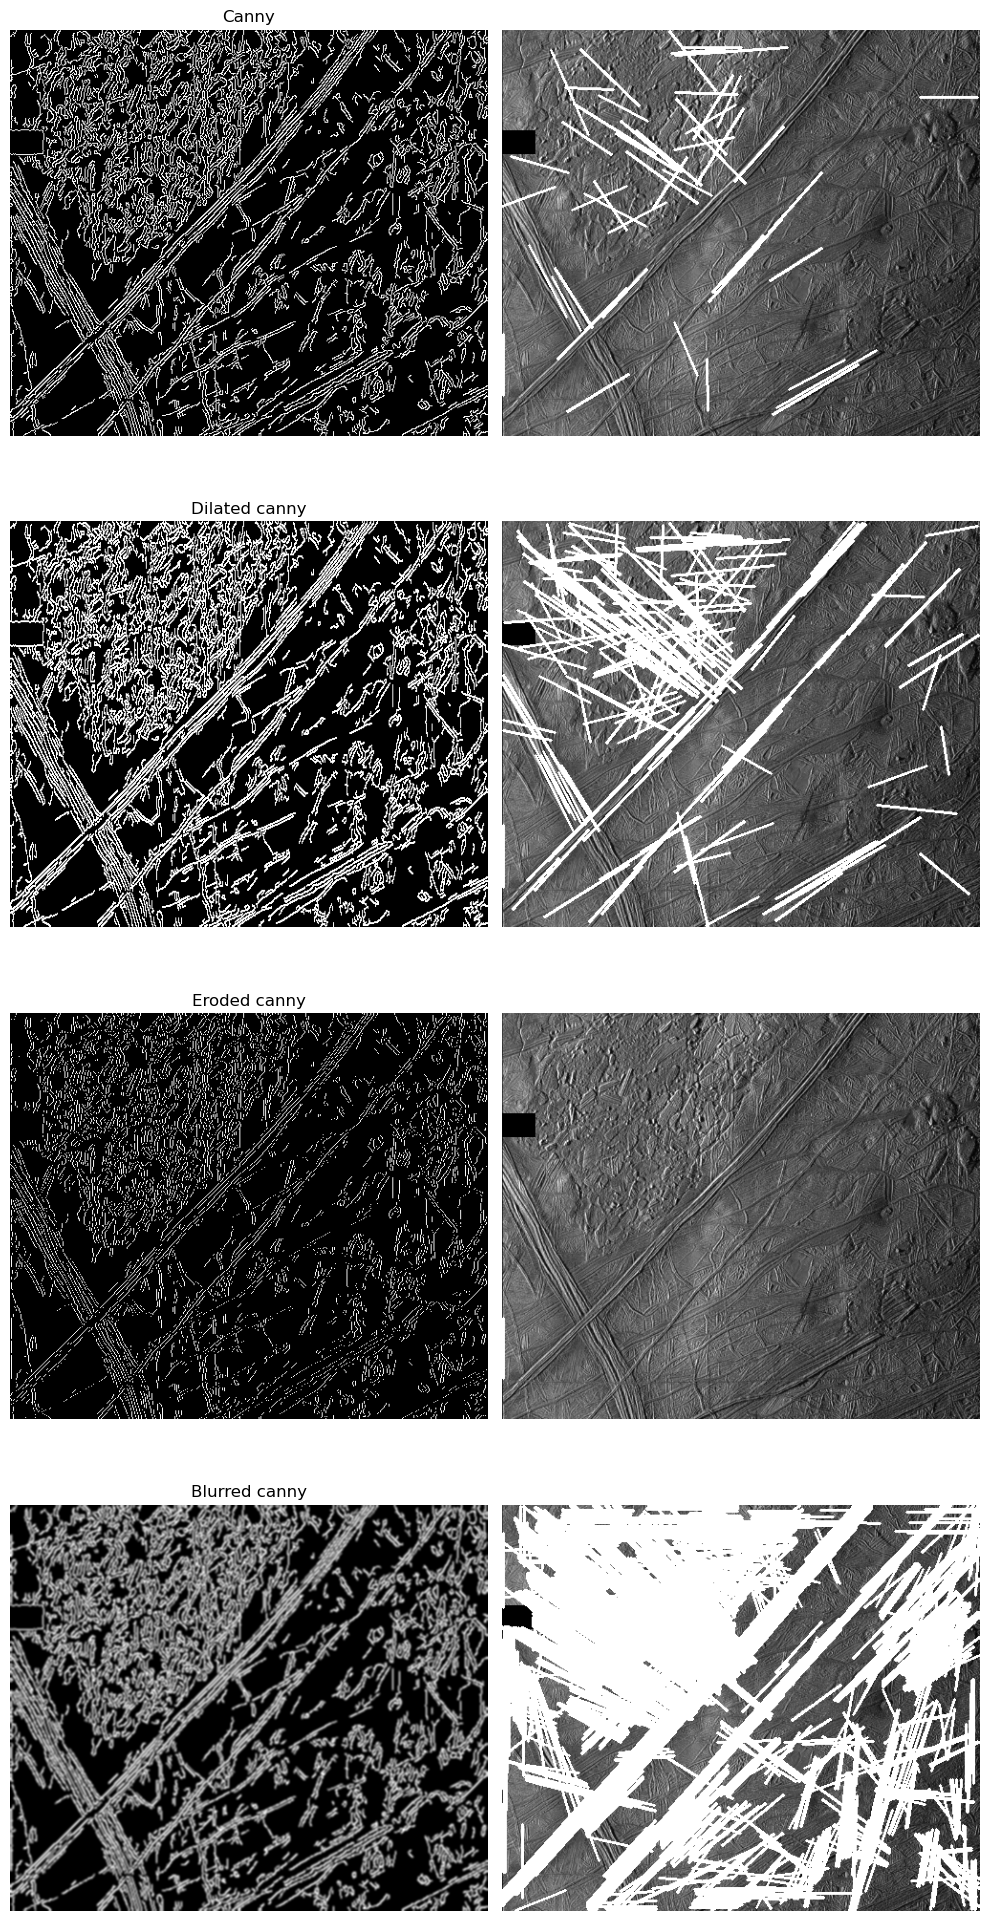

In [338]:
blurred = cv.GaussianBlur(image, (5,5), 0)
canny = auto_canny(blurred)
dilate = cv.dilate(canny, (5,5), iterations=1)
erode = cv.erode(canny, (5,5), iterations=1)
canny_blurred = cv.GaussianBlur(canny, (5,5), 0)

# Plotting
titles = ['Canny', 'Dilated canny', 'Eroded canny', 'Blurred canny']
images = [canny, dilate, erode, canny_blurred]

plt.figure(figsize=(10, 20))
for i in range(4):
    plt.subplot(4, 2, i*2+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

    plt.subplot(4, 2, i*2+2)
    plt.imshow(houghP(images[i]), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
original = cv.imread("data/europa-galileo-mosaic.png") #3350 x 3350
image = cv.cvtColor(original, cv.COLOR_BGR2GRAY)

frames = []
for i in range(10):
    row = []
    for j in range(10):
        row.append(image[335*i:335*(i+1), 335*j:335*(j+1)])
    frames.append(row)

def plotAllFrames(frames):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            plt.subplot(10, 10, i*10+j+1)
            plt.imshow(frames[i][j], cmap='gray')
            plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
plotAllFrames(frames)


In [ ]:
processed_frames = np.ones((10, 10), dtype=object)
clahe = cv.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
for i in range(10):
    for j in range(10):
        img = cv.GaussianBlur(frames[i][j], (3,3), 0)
        img = clahe.apply(frames[i][j])
        img = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[1]
        img = cv.erode(img, (5,5), iterations=5)
        processed_frames[i][j] = img
plotAllFrames(processed_frames)

In [ ]:
canny_frames = np.ones((10, 10), dtype=object)

for i in range(10):
    for j in range(10):
        img = auto_canny(processed_frames[i][j])
        canny_frames[i][j] = cv.dilate(img, (3,3), iterations=3)
plotAllFrames(canny_frames)

In [ ]:
lined_frames = np.ones((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        lined_frames[i][j] = houghP(canny_frames[i][j], output=frames[i][j])
plotAllFrames(lined_frames)